<center> 
    <h1> Space Missions - Data Analytics & Science Project </h1>
</center>
<center><img src="images/space-shuttle-774_960_720.jpg"></center>
<center>Image free to use under <a href="https://pixabay.com/photos/space-shuttle-rocket-lift-off-774/">Pixabay</a> license </center>

# Description
On this project, we analyze statistics on realistic data scraped from the web and regarding space missions. The dataset contains all the space missions since late 1957 and up to late 2020. The data contains information since the beginning of the space race between the USA and the Soviet Union and extends up to the covid-19 pandemic.

This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1).

In order to structure the notebook in an organize and concise way, the scripts which format de dataframes as well as those that plot the figures have been introduced into several folders and they are read using the *exec* command. Feel free to visit each folder to check how I coded the notebook. The structure of the project is organized as follows:

1) The data folder contains the relevant data to work the problem out.

2) The scripts folder contains the scripts to reformat the dataframe and create a couple of auxiliary ones. Inside this folder the subfolder *plot_scripts* contains the codes which create the interactiev plots using mostly plotly.

3) The image folder contains the figure you see under the title of the project.

**Remark**: The data contains some information regarding countries which has changed. We will manually update this information to work the right way. The changes in country names and land are the following::
* Russia is the Russian Federation
* New Mexico should be USA
* Yellow Sea refers to China
* Shahrud Missile Test Site should be Iran (<a href="https://www.nti.org/learn/facilities/325/">additional information</a>)
* Pacific Missile Range Facility should be USA
* Barents Sea should be Russian Federation
* Gran Canaria should be USA
* *French Algeria is now Algeria*

**Remark 2**: Some countries have leased their territory to other ones for deploying
their missiles:
* Kazakhstan was leased to Russia as can be seen in this <a href="https://en.wikipedia.org/wiki/Baikonur_Cosmodrome">link</a>
* *But launches in French Algeria were leased to France*

**Remark 3**: Sea Launch at Kiritimati started as a <a href="https://en.wikipedia.org/wiki/Sea_Launch#:~:text=Sea%20Launch%20was%20established%20in,was%20launched%20in%20March%201999.">multinational</a> business. During the period of 1995-2010 it had a shared ownership of 25% Russia, 40% USA, 20% Norway and 15% Ukraine. After a reorganization effective in October 2010, the shares are now composed of 95% Russia, 2.5% USA and 2.5% Norway. My approach will consider the ownerships as equal weights in terms of country participation.

As always, we begin a project by importing the libraries that we use at the beginning of the file. On the imports cell we also create a dictionary with the country information mentioned on the remarked paragraphs.

**Remark 4**: While the following graphics are realistic enough, for a complete foolproof revision it would be necessary to check one by one the organisations distrubution of shares over time, which may or may not add a huge increased complexity to the problem.

In [22]:
### --- Libraries --- ###

#Essentials
import numpy as np
import random
from datetime import datetime
from iso3166 import countries #iso codes for countries (DID WE USE THIS?)
import pycountry #list of countries, can be used simply with pycountry.countries (https://pypi.org/project/pycountry/)

#Data management
import pandas as pd
pd.set_option('display.max_colwidth', None)

#Sometimes Pandas will give a warning raise for valid operations 
#(see https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas)
#The following script provides a simple workaround to disable them when so desired!
class ChainedAssignent:
    def __init__(self, chained=None):
        acceptable = [None, 'warn', 'raise']
        assert chained in acceptable, "chained must be in " + str(acceptable)
        self.swcw = chained

    def __enter__(self):
        self.saved_swcw = pd.options.mode.chained_assignment
        pd.options.mode.chained_assignment = self.swcw 
        return self

    def __exit__(self, *args):
        pd.options.mode.chained_assignment = self.saved_swcw

#Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import psutil
from IPython.display import Image
from IPython.display import clear_output

### --- Changed and leased countries --- ###
#More information regarding this can be seen in the colab notebook. Basically, since the beginning of the space race and up to date, countries have changed names or leased their territory to other country

changed_countries = {'russia':'russian federation',
                     'new mexico':'usa',
                     'yellow sea':'china',
                     'shahrud missile test site':'iran',
                     'pacific missile range facility':'usa',
                     'barents sea':'russian federation',
                     'gran canaria':'usa',
                     'algeria, france':'algeria',
                     'marshall islands, usa':'usa',
                     'french guiana, france':'french guiana',
                     'kiritimati':'republic of kiribati',}

# It is also important to take into consideration which country was in charge of the mission 
leased_countries = {'russia':'russian federation',
                     'new mexico':'usa',
                     'yellow sea':'china',
                     'shahrud missile test site':'iran',
                     'pacific missile range facility':'usa',
                     'barents sea':'russian federation',
                     'gran canaria':'usa',
                     'kiritimati':'republic of kiribati',
                     'marshall islands, usa':'usa',
                     'kazakhstan':'russian federation',
                     'algeria, france':'france',
                     'french guiana, france':'france'}

# Part 1: Data reading and understanding

We start by reading the csv file 'mission_launches.csv' and explore the information contained in its columns.


In [4]:
data = pd.read_csv('data/mission_launches.csv')
data = pd.DataFrame(data)

#We can check what is contained in the dataframe with the .info() method
data.info()

#And visualize some of the data with .head() method (as well as .tail())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      4324 non-null   int64 
 1   Unnamed: 0.1    4324 non-null   int64 
 2   Organisation    4324 non-null   object
 3   Location        4324 non-null   object
 4   Date            4324 non-null   object
 5   Detail          4324 non-null   object
 6   Rocket_Status   4324 non-null   object
 7   Price           964 non-null    object
 8   Mission_Status  4324 non-null   object
dtypes: int64(2), object(7)
memory usage: 304.2+ KB


,Unnamed: 0,Unnamed: 0.1,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Center, China","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


# Part 2: Data cleansing

At a first glance, we make the following observations.

Two of the columns are Unnamed, thus we will read the data ommitting those.

The **Detail** column does not seem to be very useful for any operation we will do, so we drop it. 

The **Location** column is really important, as we will look to find a way to extract the countries from it; The objective is to create two columns: **Country** and **Location_Country**. While the first will contain the country who directed the space missions, the second will contain only the geographic information (from where the launch occurred)

The **Date** column has a type of object, which we can (and will) transform into datetime type (Note that we could read the data and declare the format at the beginning, but for the amount of data we have doing it before or after is practically the same). 

The **Rocket_Status** column takes values of "StatusActive" and "StatusRetired" only, which we will map to "Active" and "Retired". 

The **Price** column contains a lot of NaNs. Not nice. We will fill them with zeros and ignore those values when working with the prices.

I will also add a **Color** column, which will contain randomly generated colors to identify each country during this project. 

Also, let's get rid of duplicates right now.

In [5]:
exec(open("scripts/data_cleanse.py").read())

Converted "Date" column into datetime format
Added "Year" and "Year/Month" columns
Added "Country" and "Location_Country" columns
Changed Rocket StatusActive/StatusRetired to simply Active/Retired
Added randomly-generated country color codes as a column
The number of duplicated entries is: 2
Thus, we should expect to reduce the complete dataset number of entriesby a number of 1 entries.
Number of entries before dropping duplicates = 4426
Number of entries after dropping duplicates = 4425
Saved the new dataframe as "data/missions_formatted.csv"
The resulting information of the dataframe is: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4425 entries, 0 to 4425
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   Organisation      4425 non-null   object             
 1   Country           4425 non-null   object             
 2   Color             4425 non-null   object             


In [6]:
data = pd.read_csv('data/missions_formatted.csv')
data.head(10)

,Organisation,Country,Color,Year,Year/Month,Location,Location_Country,Price,Mission_Status,Rocket_Status,Date
0,SpaceX,usa,#a2518f,2020,2020-08-01,"lc-39a, kennedy space center, florida, usa",usa,50.00,Success,Active,2020-08-07 05:12:00+00:00
1,CASC,china,#95f8ab,2020,2020-08-01,"site 9401 (sls-2), jiuquan satellite launch center, china",china,29.75,Success,Active,2020-08-06 04:01:00+00:00
2,SpaceX,usa,#a2518f,2020,2020-08-01,"pad a, boca chica, texas, usa",usa,0.00,Success,Active,2020-08-04 23:57:00+00:00
3,Roscosmos,russian federation,#5972a5,2020,2020-07-01,"site 200/39, baikonur cosmodrome, kazakhstan",kazakhstan,65.00,Success,Active,2020-07-30 21:25:00+00:00
4,ULA,usa,#a2518f,2020,2020-07-01,"slc-41, cape canaveral afs, florida, usa",usa,145.00,Success,Active,2020-07-30 11:50:00+00:00
5,CASC,china,#95f8ab,2020,2020-07-01,"lc-9, taiyuan satellite launch center, china",china,64.68,Success,Active,2020-07-25 03:13:00+00:00
6,Roscosmos,russian federation,#5972a5,2020,2020-07-01,"site 31/6, baikonur cosmodrome, kazakhstan",kazakhstan,48.50,Success,Active,2020-07-23 14:26:00+00:00
7,CASC,china,#95f8ab,2020,2020-07-01,"lc-101, wenchang satellite launch center, china",china,0.00,Success,Active,2020-07-23 04:41:00+00:00
8,SpaceX,usa,#a2518f,2020,2020-07-01,"slc-40, cape canaveral afs, florida, usa",usa,50.00,Success,Active,2020-07-20 21:30:00+00:00
9,JAXA,japan,#e40176,2020,2020-07-01,"la-y1, tanegashima space center, japan",japan,90.00,Success,Active,2020-07-19 21:58:00+00:00


# Part 3: Data visualization

## Generic visualizations: Chloropet map

To begin the analysis of the problem, I decided to start with some all-in-one visualization methods. 
The simplest variable to analyze is the number of launches a country has done since the beginning of the first spatial mission and up to date. For this purpose, the ideal representation is the employment of a <a href="https://en.wikipedia.org/wiki/Choropleth_map#:~:text=A%20choropleth%20map%20(from%20Greek,each%20area%2C%20such%20as%20population">choropleth map</a>. Such graphic thematically represents a set of pre-defined areas in coloured proportions with regards to a statistical variable that represents an aggregate summary of a geographic characteristic within each region. Particularly to this situation, the statistical variable corresponds to the number of launches a country has done.

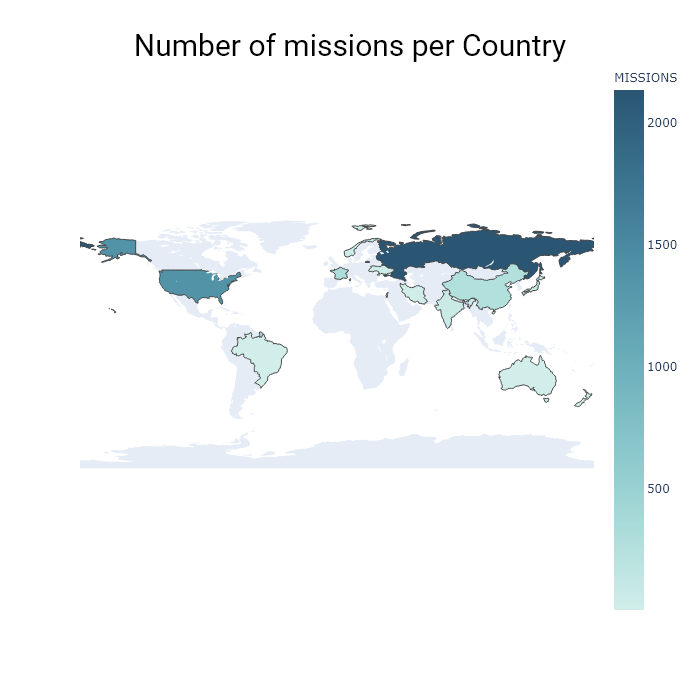

In [24]:
exec(open("scripts/plot_scripts/plot_1_chloropeth_missions.py").read())
clear_output()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

## Generic visualizations: Sunburst chart

Another way to exhibit generic statistics without much detail could be to employ a complete <a href="https://www.anychart.com/chartopedia/chart-type/sunburst-chart/">sunburst chart</a>. The following cell generates a sunburst chart where the size of the parent pies are determined by which country launched the most missions along all these years and the chosen hierarchies are: 
country $\rightarrow$ organisation $\rightarrow$ successful/failed mission.

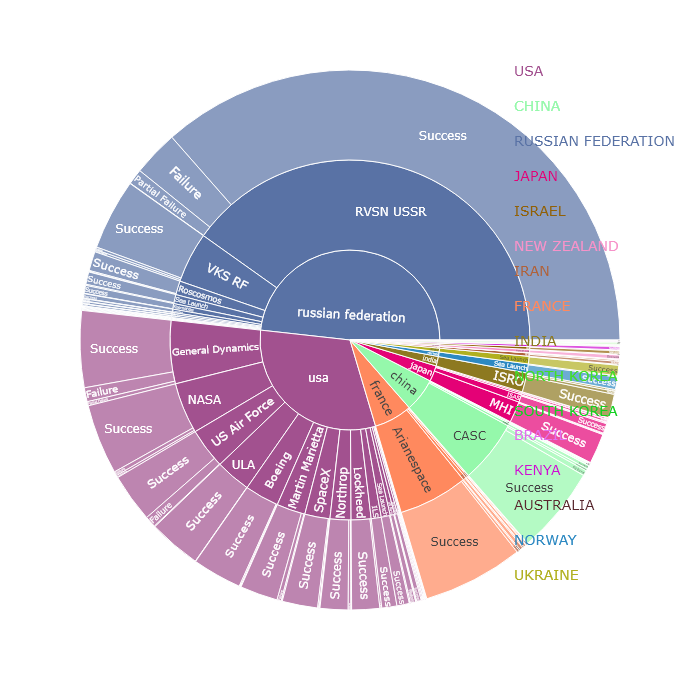

In [27]:
exec(open("scripts/plot_scripts/plot_2_sunburst_missions.py").read())
img_bytes = fig.to_image(format="png")
clear_output()
Image(img_bytes)

From these graphics, we can see that the big fishes in the pond are both the Russian Federation and the USA, followed up by France and the rapidly growing China. From now on, we present a detailed analysis of the dataset we have in our hands.
## Year-on-year analysis

First, we will look into the year-by-year statistics of the given information. To achieve this, we create a new dataframe which contains the relevant information for this analysis. The information on this dataframe will contain:

* The **Year** of interest.
* The **Mission** column, which will contain how many missions occurred on a given year. As a complement, we will also add columns to keep track of how many of these were successful and failures.
* The **Status: Active** and **Status: Retired** columns, which will count how many of the missions still possess an active rocket on space.
* The **Top_organisation** columns to keep track of which organisation deployed the most missions on the given year, to which country it refers and how many missions it deployed.
* An analogue set of columns but regarding the **Top_country**.
* A **Color** code column, which will serve to identify each country on a figure.

In [9]:
exec(open("scripts/data_year-by-year.py").read())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Year                        64 non-null     int64 
 1   Missions                    64 non-null     int64 
 2   Mission: Success            64 non-null     int32 
 3   Mission: Failure            64 non-null     int32 
 4   Mission: Partial Failure    64 non-null     int32 
 5   Mission: Prelaunch Failure  64 non-null     int32 
 6   Mission: Non Success        64 non-null     int32 
 7   Status: Active              64 non-null     int32 
 8   Status: Retired             64 non-null     int32 
 9   Top_organisation            64 non-null     object
 10  Top_organisation_country    64 non-null     object
 11  Top_organisation_count      64 non-null     object
 12  Top_country                 64 non-null     object
 13  Top_country_count           64 non-null     object
 

In [10]:
yby = pd.read_csv('data/data_yby.csv')
yby.head(10)

,Year,Missions,Mission: Success,Mission: Failure,Mission: Partial Failure,Mission: Prelaunch Failure,Mission: Non Success,Status: Active,Status: Retired,Top_organisation,Top_organisation_country,Top_organisation_count,Top_country,Top_country_count,Color
0,1957,3,2,1,0,0,1,0,3,RVSN USSR,russian federation,RVSN USSR (2),russian federation,russian federation (2),#5972a5
1,1958,28,6,20,2,0,22,0,28,US Navy,usa,US Navy (12),usa,usa (23),#a2518f
2,1959,20,8,9,3,0,12,0,20,US Air Force,usa,US Air Force (10),usa,usa (16),#a2518f
3,1960,39,19,20,0,0,20,0,39,US Air Force,usa,US Air Force (21),usa,usa (30),#a2518f
4,1961,52,32,17,3,0,20,0,52,US Air Force,usa,US Air Force (23),usa,usa (43),#a2518f
5,1962,82,65,15,2,0,17,0,82,US Air Force,usa,US Air Force (41),usa,usa (60),#a2518f
6,1963,41,29,12,0,0,12,0,41,RVSN USSR,russian federation,RVSN USSR (24),russian federation,russian federation (24),#5972a5
7,1964,60,48,10,2,0,12,0,60,RVSN USSR,russian federation,RVSN USSR (36),russian federation,russian federation (36),#5972a5
8,1965,87,74,11,2,0,13,0,87,RVSN USSR,russian federation,RVSN USSR (53),russian federation,russian federation (53),#5972a5
9,1966,101,81,10,9,1,20,0,101,RVSN USSR,russian federation,RVSN USSR (51),russian federation,russian federation (51),#5972a5


### Year-on-year analysis: Missions per year

When understanding the space missions information provided by the data, we will go from generic to specific.  In the generic point of view, two main aspects spur our interest. 

On the one hand, we plot the distribution of missions year by year. Plotting this information provides a better understanding of the priorities assigned to space missions during different time periods.

On the other hand, how does the number of successful and failed launches vary over time? Intuitively (and hopefully), we should expect to see that we humans get better at launching missions, and the failure ratio to decrease drastically. We will also take a peek at the percentage regarding how many of the successful missions still posses an active rocket.

The following cells of the notebook will create such graphics using the information provided on the cleaned dataset and the generated year-by-year dataset.

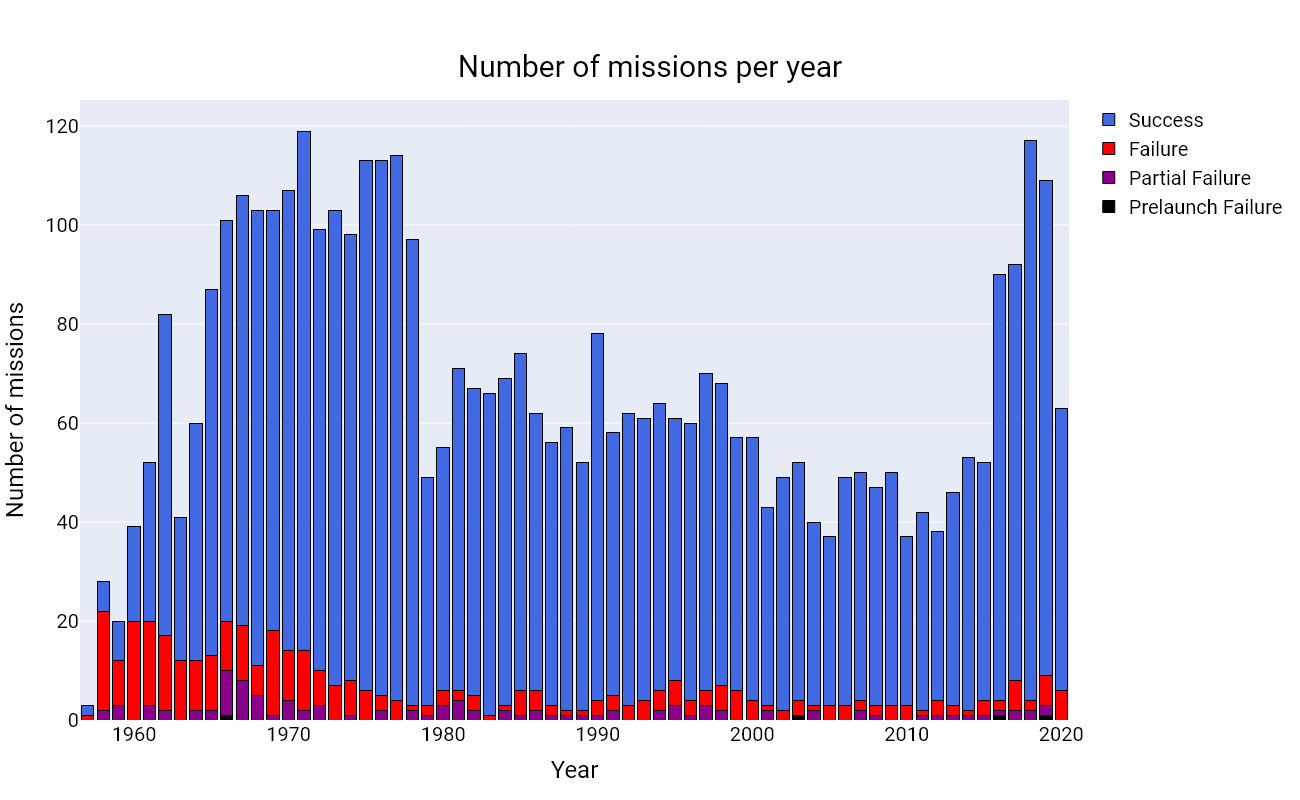

In [28]:
exec(open("scripts/plot_scripts/plot_3_missions_per_year.py").read())
img_bytes = fig.to_image(format="png")
clear_output()
Image(img_bytes)

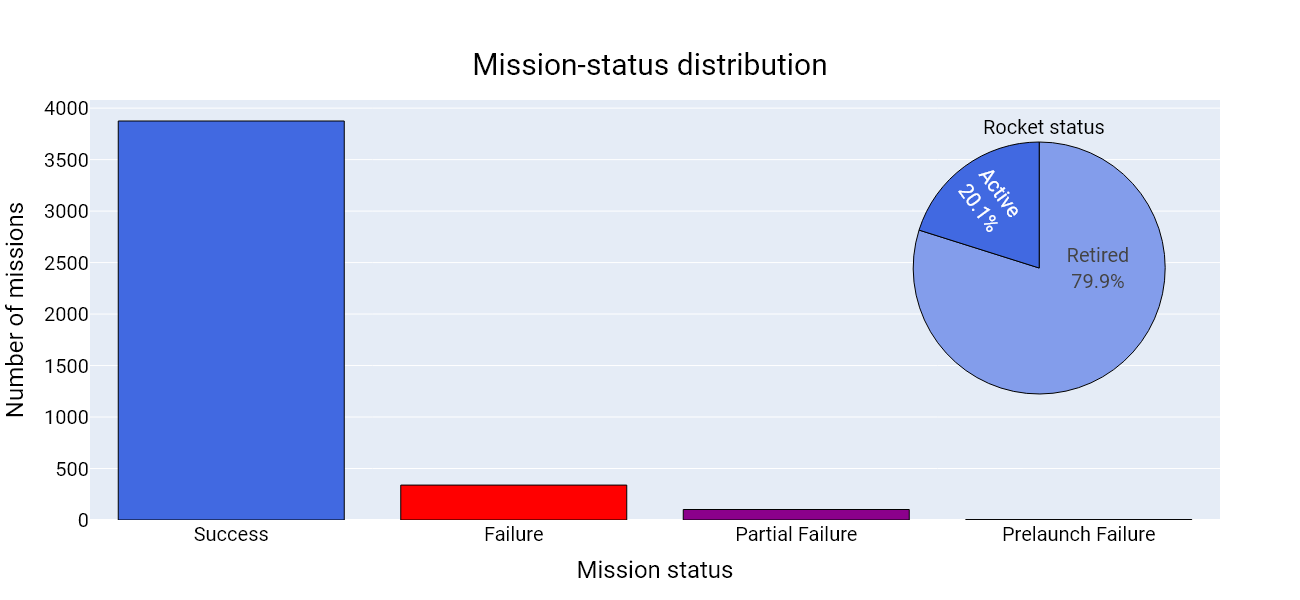

In [29]:
exec(open("scripts/plot_scripts/plot_4_status_mission_and_rocket.py").read())
img_bytes = fig.to_image(format="png")
clear_output()
Image(img_bytes)

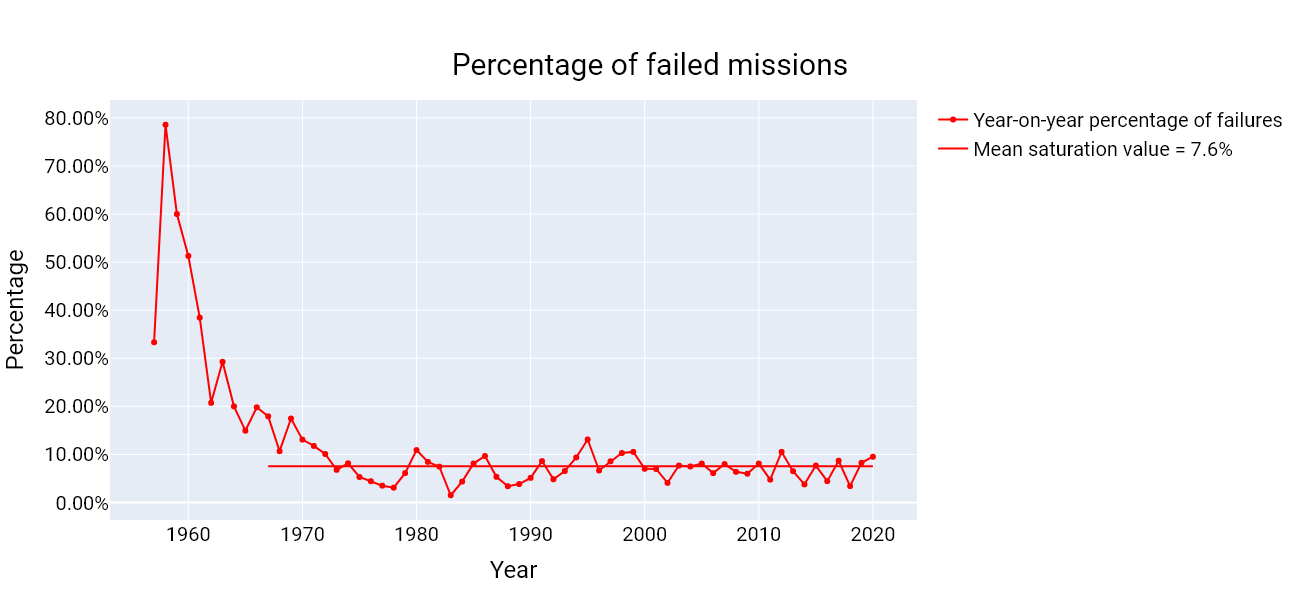

In [30]:
exec(open("scripts/plot_scripts/plot_5_percentage_failures.py").read())
img_bytes = fig.to_image(format="png")
clear_output()
Image(img_bytes)

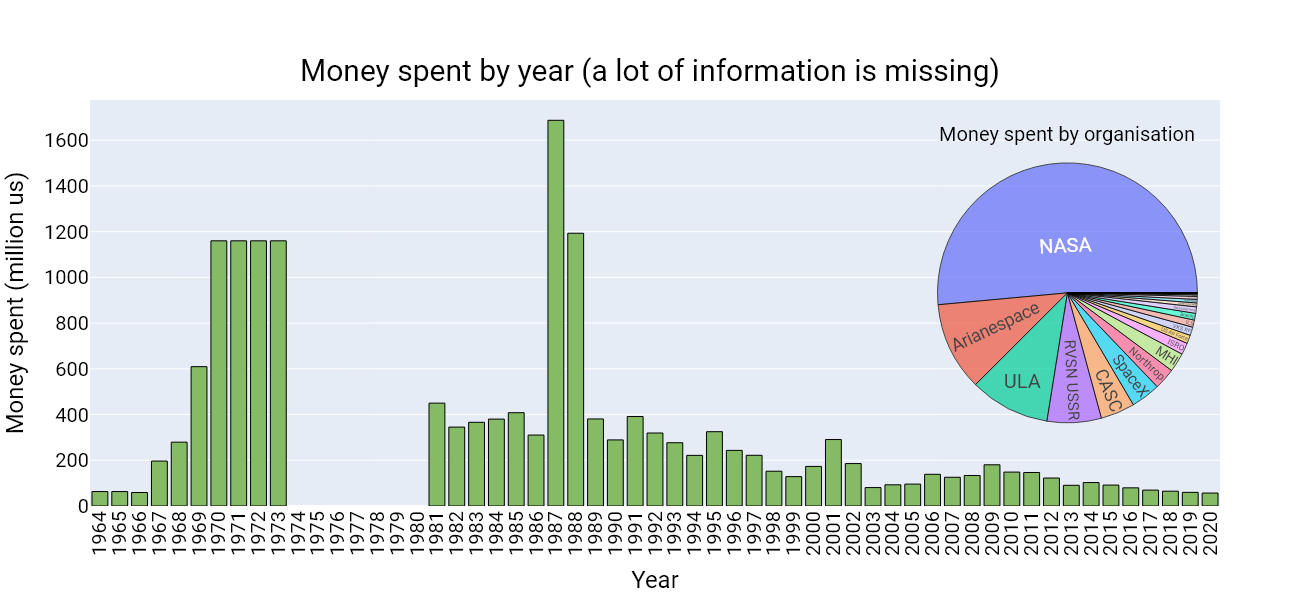

In [31]:
exec(open("scripts/plot_scripts/plot_6_money_by_year.py").read())
img_bytes = fig.to_image(format="png")
clear_output()
Image(img_bytes)

As can be seen, the period between 1957 to the late 1970s was the spark of the spatial missions. While the number of launches increased over time, the percentage of failed ones decreased drastically. 

From 1980 onwards mid-2010 the number of missions remained statistically a constant over time, and the percentage of failures remains small up to date with a mean value of 7.6%. 

The last five years emerged a reignition of the number of spatial missions.

In terms of spent money, we have a lot of missing information. Therefore, the results obtained in the plot are not trustworthy. 

### Year-on-year analysis: The big fish

In terms of both organisations and countries, how was their dominance over time? We will explore this question by plotting the distribution of the top organisation and top country per year. When referring to top, we refer to the one that launched the most missions on the given year.

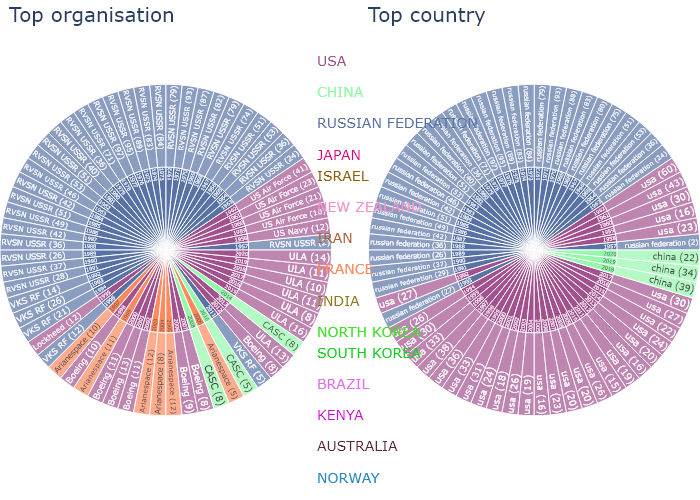

In [32]:
exec(open("scripts/plot_scripts/plot_7_big_fish.py").read())
img_bytes = fig.to_image(format="png")
clear_output()
Image(img_bytes)

We can see that the USA was dominant during the period of [1957,1962], from which the Russian federation takes over the leadership in the number of launches up until 1991. From then onwards, the organisations with the most launches alternate between France, USA, Russia and China. The latter of which takes dominance over the last three years.

Following this analysis up, it is interesting how the organisations worked year by year, and how their dominance changed. The following cell will create a plot to illustrate how the top 10 players with the most launches divided them over the years.

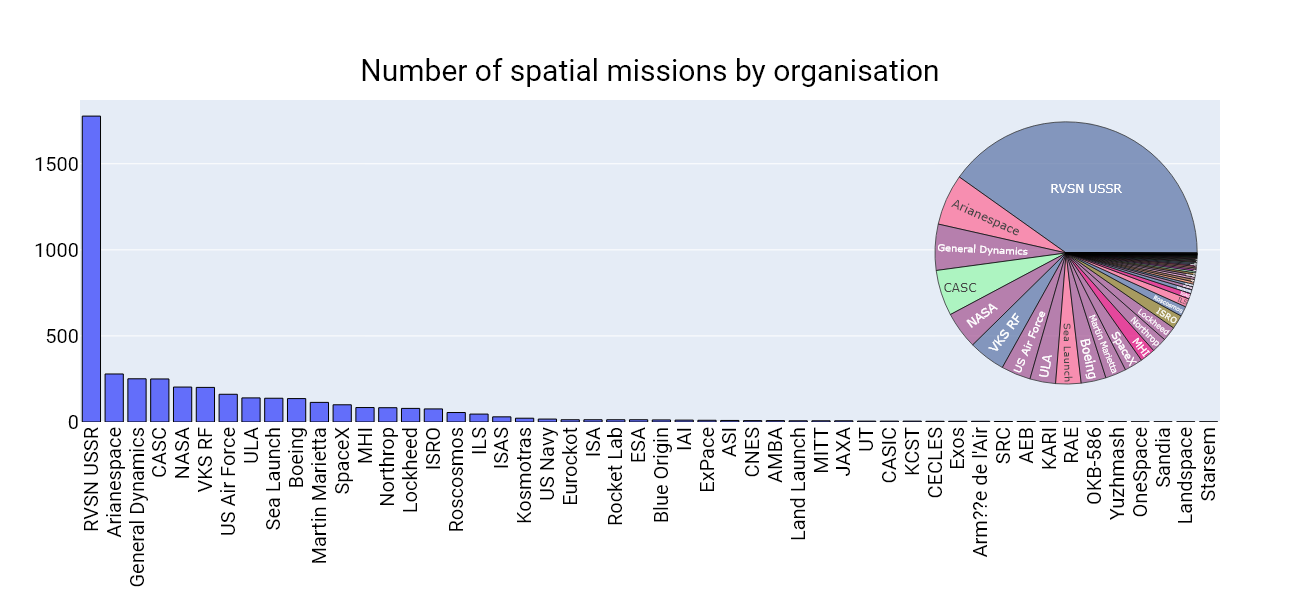

In [34]:
exec(open("scripts/plot_scripts/plot_8_missions_per_org.py").read())
img_bytes = fig.to_image(format="png")
clear_output()
Image(img_bytes)

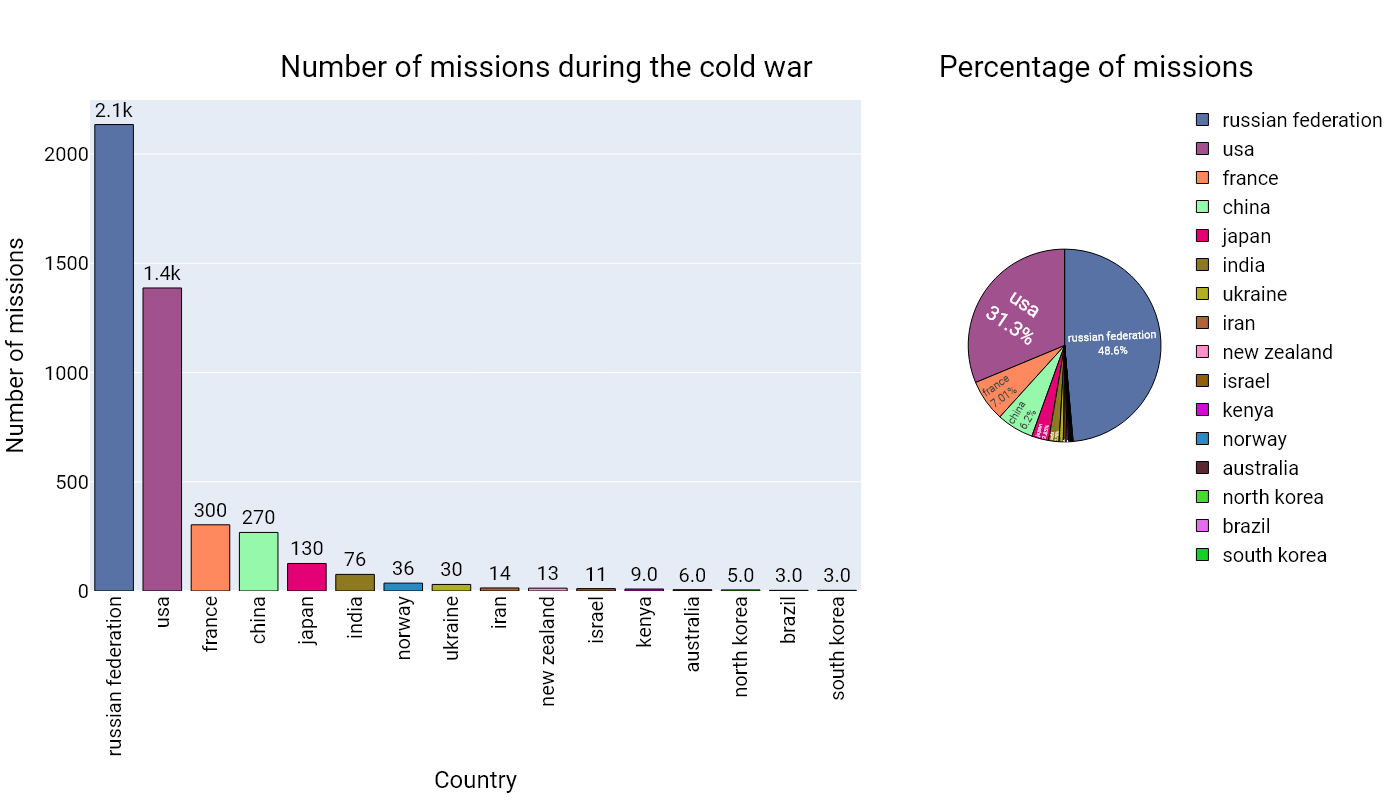

In [35]:
exec(open("scripts/plot_scripts/plot_9_missions_per_country.py").read())
img_bytes = fig.to_image(format="png")
clear_output()
Image(img_bytes)

*Remark*: An important thing to notice about plotly is that it does not support grouped legends between different plots!!!

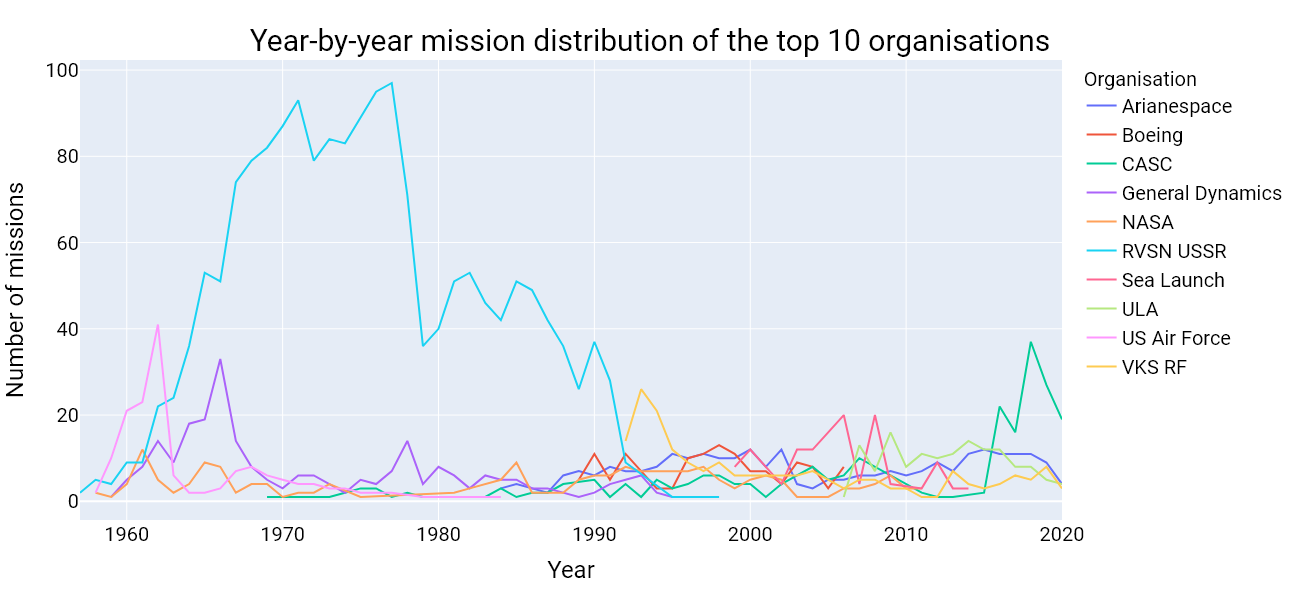

In [36]:
exec(open("scripts/plot_scripts/plot_10_organisations_yby.py").read())
img_bytes = fig.to_image(format="png")
clear_output()
Image(img_bytes)

# Cold War Space Race: URSS vs USA

The cold war starts at the beginning of the dataset up to 1991, let's see what happened. On the first cell we will define an auxiliary space race dataframe to simplyfy thing, and the analysis comes further down.

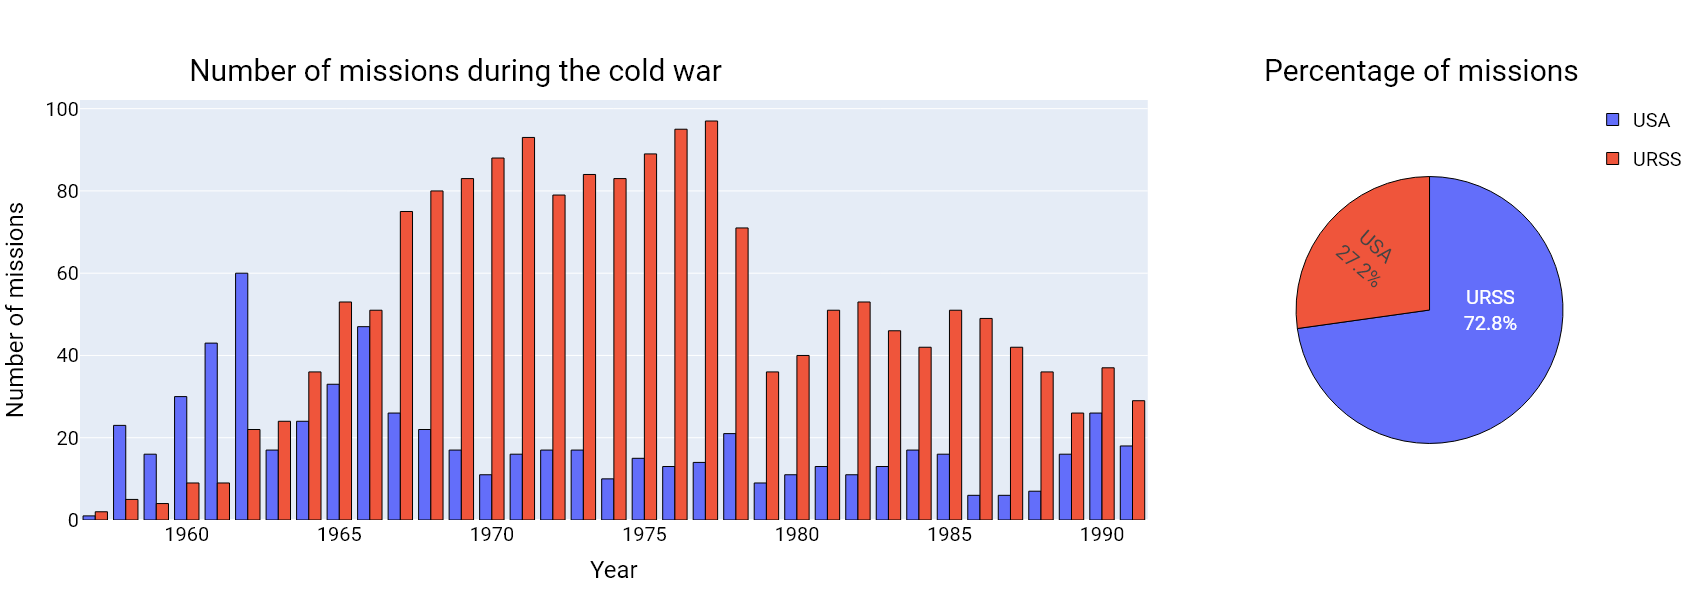

In [37]:
exec(open("scripts/plot_scripts/plot_11_cold_war.py").read())
img_bytes = fig.to_image(format="png")
clear_output()
Image(img_bytes)